In [1]:
import os

import numpy as np
import pandas as pd
import graph_tool.all as gt
import matplotlib.pyplot as plt
import seaborn as sns

gt.seed_rng(1)
np.random.seed(1)

In [2]:
# relevant file paths
data_dir = './data'
processed_graph = os.path.join(data_dir, 'eadage_generic_graph_unsigned.gt')

In [3]:
G = gt.load_graph(processed_graph)
# make sure vertex/edge properties exist
print(G)
print(list(G.vp.keys()))
print(list(G.ep.keys()))

<Graph object, undirected, with 3477 vertices and 31556 edges, 2 internal vertex properties, 1 internal edge property, at 0x7f0c8f619a90>
['name', 'is_generic']
['weight']


In [4]:
# plot degree distribution + look at degrees of generic genes
vs = G.get_vertices()
names = [G.vp['name'][v] for v in vs]
is_generic = [G.vp['is_generic'][v] for v in vs]
degrees = G.get_total_degrees(vs)
degree_df = pd.DataFrame({
    'gene': names,
    'degree': degrees,
    'is_generic': is_generic
})
degree_df.sort_values(by='degree', ascending=False).head()

,gene,degree,is_generic
26,PA4238,209,0
29,PA4245,201,0
30,PA4247,192,0
79,PA4252,181,0
27,PA4239,180,0


Text(0.5, 1.0, 'Degree distribution of generic/non-generic genes')

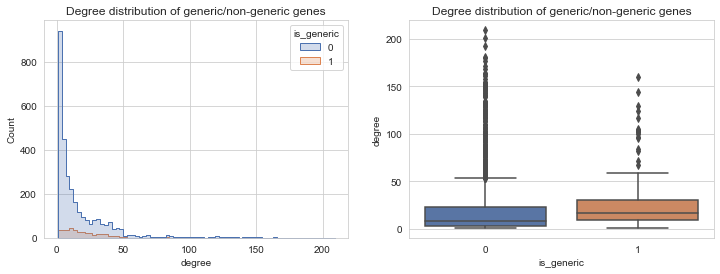

In [5]:
sns.set({'figure.figsize': (12, 4)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 2)
sns.histplot(data=degree_df, x='degree', hue='is_generic', element='step', ax=axarr[0])
axarr[0].set_title('Degree distribution of generic/non-generic genes')
sns.boxplot(data=degree_df, y='degree', x='is_generic', ax=axarr[1])
axarr[1].set_title('Degree distribution of generic/non-generic genes')

In [6]:
# plot weight distribution + look at weights of edges including generic genes
# (v1, v2, weight, is_generic)
edges = []
for s, t, w in G.iter_edges([G.ep['weight']]):
    if (G.vp['is_generic'][s]) and (G.vp['is_generic'][t]):
        is_generic = 2
    elif (G.vp['is_generic'][s]) or (G.vp['is_generic'][t]):
        is_generic = 1
    else:
        is_generic = 0
    edges.append((G.vp['name'][s], G.vp['name'][t], w, is_generic))
weight_df = pd.DataFrame(edges, columns=['g1', 'g2', 'weight', 'is_generic'])
print(weight_df.shape)
weight_df.head()

(31556, 4)


,g1,g2,weight,is_generic
0,PA0001,PA0002,0.578872,0
1,PA0001,PA0548,0.510323,0
2,PA0001,PA0963,0.561494,0
3,PA0001,PA3637,0.512365,0
4,PA0001,PA5554,0.554768,1


Text(0.5, 1.0, 'Weight distribution of generic/non-generic edges')

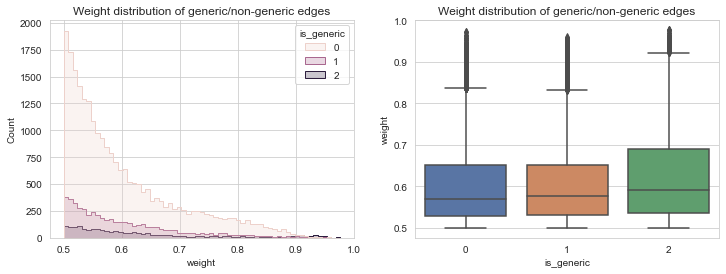

In [7]:
sns.set({'figure.figsize': (12, 4)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 2)
sns.histplot(data=weight_df, x='weight', hue='is_generic', element='step', ax=axarr[0])
axarr[0].set_title('Weight distribution of generic/non-generic edges')
sns.boxplot(data=weight_df, y='weight', x='is_generic', ax=axarr[1])
axarr[1].set_title('Weight distribution of generic/non-generic edges')

In [8]:
# add distance = 1 - edge weight to graph as edge property
#
# betweenness centrality looks for shortest paths, but since our edge weights
# represent similarity, we need to convert them to distance - taking 1 - 
# similarity is a simple way to do this
eprop_distance = G.new_edge_property('float')
for e in G.edges():
    eprop_distance[e] = 1 - G.ep['weight'][e]
G.ep['distance'] = eprop_distance
print(list(G.ep.keys()))

['weight', 'distance']


In [9]:
# analyze betweenness centrality for generic vs. other genes
def betweenness_to_df(G, v_bw):
    vs = G.get_vertices()
    return pd.DataFrame({
        'gene': [G.vp['name'][v] for v in vs],
        'betweenness': [v_bw[v] for v in vs],
        'is_generic': [G.vp['is_generic'][v] for v in vs]
    })

v_bw, _ = gt.betweenness(G, weight=G.ep['distance'])
bw_df = betweenness_to_df(G, v_bw)
bw_df.head()

,gene,betweenness,is_generic
0,PA0001,1.655752e-07,0
1,PA0002,1.056205e-03,0
2,PA0548,9.454347e-05,0
3,PA0963,1.887558e-05,0
4,PA3637,4.420859e-05,0


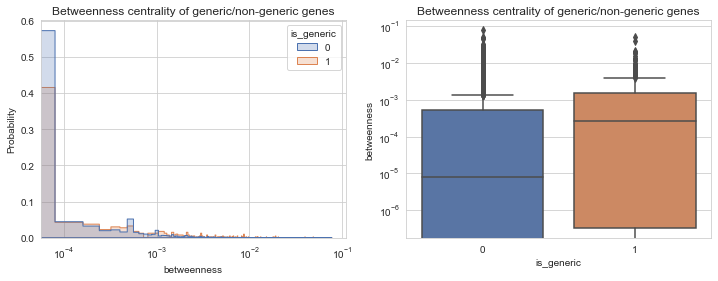

In [10]:
sns.set({'figure.figsize': (12, 4)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 2)
sns.histplot(data=bw_df, x='betweenness', hue='is_generic', element='step',
             stat='probability', common_norm=False, ax=axarr[0])
axarr[0].set_title('Betweenness centrality of generic/non-generic genes')
axarr[0].set_xscale('log')
# axarr[0].set_yscale('log')
sns.boxplot(data=bw_df, y='betweenness', x='is_generic', ax=axarr[1])
axarr[1].set_title('Betweenness centrality of generic/non-generic genes')
axarr[1].set_yscale('log')

In [11]:
# analyze betweenness centrality for generic vs. other genes
pr = gt.pagerank(G, weight=G.ep['distance'])
pr_df = (
    betweenness_to_df(G, pr)
        .rename(columns={'betweenness': 'pagerank'})
)
pr_df.head()

,gene,pagerank,is_generic
0,PA0001,0.000096,0
1,PA0002,0.000450,0
2,PA0548,0.000406,0
3,PA0963,0.000337,0
4,PA3637,0.000591,0


Text(0.5, 1.0, 'PageRank of generic/non-generic genes')

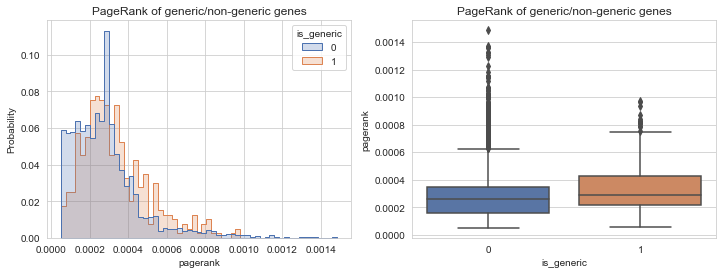

In [12]:
sns.set({'figure.figsize': (12, 4)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 2)
sns.histplot(data=pr_df, x='pagerank', hue='is_generic', element='step',
             stat='probability', common_norm=False, ax=axarr[0])
axarr[0].set_title('PageRank of generic/non-generic genes')
sns.boxplot(data=pr_df, y='pagerank', x='is_generic', ax=axarr[1])
axarr[1].set_title('PageRank of generic/non-generic genes')